In [1]:
import torch
import jieba
import random

import numpy as np

from data import Data
from torch import nn, optim
from datetime import datetime
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset

c:\Users\User\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set random seed.
random_seed = 0

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda:0"

print(device)

cuda:0


In [4]:
classes = {
    0: "牡羊",
    1: "金牛",
    2: "雙子",
    3: "巨蠍",
    4: "獅子",
    5: "處女",
    6: "天秤",
    7: "天蠍",
    8: "射手",
    9: "魔羯",
    10: "水瓶",
    11: "雙魚",
}

In [5]:
raw = {i: open(f"./dataset/{classes[i]}.txt", encoding="utf-8").read() for i in range(12)}
data = Data(data=raw, padding_length=32)

train_raw = data.get("data")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache


Cleaning completed.
ToDataset completed.
Argumantation completed.


Loading model cost 0.742 seconds.
Prefix dict has been built successfully.


Tokenlization completed.
Padding completed.
Token2id completed.
Process completed.


In [6]:
len(train_raw)

6327

In [7]:
train_raw[0]

[[480,
  5416,
  2464,
  979,
  1876,
  2320,
  3810,
  1178,
  1213,
  3695,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516,
  516],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [8]:
class CreateDataset(Dataset):
    def __init__(self, data: list, label: list):
        self.data = data
        self.label = label

    def __getitem__(self, index):
        return torch.tensor(self.data[index]), torch.tensor(self.label[index], dtype=torch.float)

    def __len__(self):
        return len(self.label)

In [9]:
d, l = [], []

for i, j in train_raw:
    d.append(i); l.append(j)

train_ds = CreateDataset(d, l)

In [10]:
train_ds[1]

(tensor([ 480, 5416, 2464,  979, 1876, 2320, 3810, 1178, 1213, 3695,  516,  516,
          516,  516,  516,  516,  516,  516,  516,  516,  516,  516,  516,  516,
          516,  516,  516,  516,  516,  516,  516,  516]),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [11]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

In [12]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.embedding = nn.Embedding(data.get("token_len"), 64)
        self.lstm = nn.LSTM(input_size=64, hidden_size=256, num_layers=4, dropout=0.5, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(16384, 12)

    def forward(self, x: torch.Tensor):
        x = self.embedding(x)
        x, _ = self.lstm(x)

        x = x.reshape(x.size()[0], -1)

        x = self.linear(x)

        return x

In [13]:
model = Model().to(device=device)

In [14]:
epochs = 30
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss = nn.CrossEntropyLoss()

In [15]:
# Traning history data.
train_accuracy_h = []
train_loss_h = []
validate_accuracy_h = []

In [16]:
def train(epochs: int, model: nn.Module, optimizer: optim.Optimizer, loss: nn.CrossEntropyLoss, dataloader: DataLoader):
    for epoch in range(epochs):
        # Set model to training mode.
        model.train()

        train_accuracy = 0
        train_loss = 0
        train_total = 0
        train_process = 0
        train_time = datetime.now().timestamp()

        for texts, labels in dataloader:
            texts: torch.Tensor
            labels: torch.Tensor

            texts = texts.to(device)
            labels = labels.to(device)

            outputs: torch.Tensor = model(texts)
            losses: torch.Tensor = loss(outputs, labels)

            # optimizer.zero_grad()
            for param in model.parameters(): param.grad = None

            # Backpropagation.
            losses.backward()

            # Update parameters.
            optimizer.step()

            _, predict = torch.max(outputs, 1)
            train_accuracy += sum([labels[i][predict[i]] == 1 for i in range(len(predict))])
            train_loss += losses.item()
            train_total += labels.shape[0]
            train_process += 1

            print(
                f"{datetime.now().strftime('%Y/%m/%d %H:%M:%S')} "
                f"Epoch: {epoch:03d} "
                f"Time: {datetime.now().timestamp() - train_time:.2f} "
                f"Process: {train_process / len(dataloader) * 100:.2f}% "
                f"Accuracy: {train_accuracy / train_total * 100:.2f}% "
                f"Loss: {train_loss:.3f}",
                end="\r"
            )

        train_accuracy_h.append(train_accuracy / train_total * 100)
        train_loss_h.append(train_loss)

        print()

        # Early stop.
        if train_accuracy / train_total > 0.99:
            print("Early stopped.")
            break

In [17]:
train(epochs=epochs, model=model, optimizer=optimizer, loss=loss, dataloader=train_dl)

2024/03/31 19:28:49 Epoch: 000 Time: 18.58 Process: 100.00% Accuracy: 10.89% Loss: 1961.231
2024/03/31 19:29:06 Epoch: 001 Time: 17.25 Process: 100.00% Accuracy: 13.39% Loss: 1938.162
2024/03/31 19:29:23 Epoch: 002 Time: 17.07 Process: 100.00% Accuracy: 20.10% Loss: 1832.530
2024/03/31 19:29:40 Epoch: 003 Time: 17.05 Process: 100.00% Accuracy: 29.00% Loss: 1658.829
2024/03/31 19:29:57 Epoch: 004 Time: 17.40 Process: 100.00% Accuracy: 37.19% Loss: 1477.256
2024/03/31 19:30:15 Epoch: 005 Time: 17.27 Process: 100.00% Accuracy: 47.32% Loss: 1271.085
2024/03/31 19:30:32 Epoch: 006 Time: 17.00 Process: 100.00% Accuracy: 57.74% Loss: 1031.924
2024/03/31 19:30:49 Epoch: 007 Time: 17.18 Process: 100.00% Accuracy: 69.42% Loss: 766.134
2024/03/31 19:31:06 Epoch: 008 Time: 17.57 Process: 100.00% Accuracy: 78.55% Loss: 525.340
2024/03/31 19:31:24 Epoch: 009 Time: 17.51 Process: 100.00% Accuracy: 85.66% Loss: 351.213
2024/03/31 19:31:41 Epoch: 010 Time: 16.89 Process: 100.00% Accuracy: 91.48% Loss: 

In [18]:
for i, j in train_dl:
    print(i)
    print(model(i.to(device)))
    print(j)
    break

tensor([[2863, 4233, 1383, 4102, 5416, 1727, 2169, 1178, 2825, 1090, 5242, 1257,
          987,  923, 1876, 5300, 2549, 1876, 3754, 2937, 2123, 3695,  516,  516,
          516,  516,  516,  516,  516,  516,  516,  516],
        [3239, 4395, 2067, 2940, 2916, 2453, 2343, 1436, 5242, 2987, 2538,  266,
         3484,  162, 1653,  492, 1727,  538, 3695,  516,  516,  516,  516,  516,
          516,  516,  516,  516,  516,  516,  516,  516],
        [4306, 5242, 2863, 4233, 5162, 1682, 2904, 2323, 2942,  425, 5242, 3484,
          427, 4207, 1178, 4999, 2807, 5162, 1682, 2439, 2942, 4013,  355, 1178,
          778, 3695,  516,  516,  516,  516,  516,  516],
        [3994, 2863, 4233,  767, 4272, 2942,   26, 2807, 5242, 5162, 1682, 3452,
         3777, 1141, 1178, 2081, 5242, 2497, 1314, 1178,  923, 1885, 5107, 2453,
         1106, 1697, 3695,  516,  516,  516,  516,  516],
        [1584, 3827, 1876,  283, 1876,  972, 1876, 3960, 1876,  257,   33,  611,
         1157, 1876, 3369, 1876,  659, 

In [162]:
test = "敏感善良，充滿了同情心和想像力，他們常常是理想主義者和夢想家，追求著內心的情感和精神實踐。"
temp = jieba.lcut(test)
temp = temp + ["<PAD>"] * (32 - len(temp))
test = [data.w2i[x] if x in data.w2i else data.w2i["<PAD>"] for x in temp][:32]
print(test)

[3379, 1917, 5242, 1327, 3892, 2696, 2453, 3522, 5242, 266, 3046, 480, 4537, 3142, 2453, 4075, 5282, 5242, 4434, 516, 1178, 2258, 2453, 3233, 2482, 3695, 516, 516, 516, 516, 516, 516]


In [163]:
test = torch.tensor([test])

In [164]:
model.eval()

Model(
  (embedding): Embedding(5470, 64)
  (lstm): LSTM(64, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=16384, out_features=12, bias=True)
)

In [165]:
result = model(test.to(device)).tolist()[0]
print(result)

[-2.2450976371765137, -2.7666144371032715, -8.517983436584473, 8.639778137207031, -5.704585075378418, -6.402193546295166, 1.144858479499817, -6.030594825744629, 8.116000175476074, 0.7590525150299072, 1.170964002609253, 11.647222518920898]


In [166]:
# Normolization
result = [x - min(result) for x in result]
result = [x / max(result) for x in result]
result = [round(x, 3) for x in result]

print(result)

[0.311, 0.285, 0.0, 0.851, 0.14, 0.105, 0.479, 0.123, 0.825, 0.46, 0.48, 1.0]


In [167]:
classes[int(torch.argmax(torch.tensor(result)))]

'雙魚'

In [168]:
classes

{0: '牡羊',
 1: '金牛',
 2: '雙子',
 3: '巨蠍',
 4: '獅子',
 5: '處女',
 6: '天秤',
 7: '天蠍',
 8: '射手',
 9: '魔羯',
 10: '水瓶',
 11: '雙魚'}

In [169]:
import matplotlib.pyplot as plt
import numpy as np

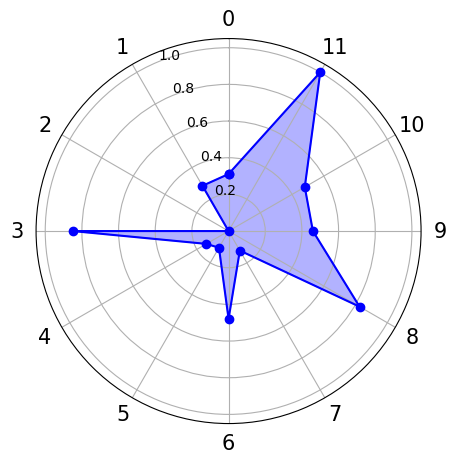

In [170]:
angles_A = np.linspace(start=0, stop=2*np.pi, num=len(result)+1, endpoint=True)
values_A = np.concatenate((result, [result[0]]))

fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={'projection': 'polar'})
ax.plot(angles_A, values_A, 'o-', color="blue", label="A")

ax.fill(angles_A, values_A, alpha=0.3, color="blue")
ax.set_thetagrids(angles_A[:-1] * 180 / np.pi, range(12), fontsize=15)
ax.set_theta_zero_location('N')

In [171]:
torch.onnx.export(model, test.to(device=device), 'constellator.onnx')

In [172]:
import onnx
import onnx.helper

onnx_model = onnx.load('./constellator.onnx')
print(onnx.helper.printable_graph(onnx_model.graph))

graph torch_jit (
  %input.1[INT64, 1x32]
) initializers (
  %embedding.weight[FLOAT, 5470x64]
  %linear.weight[FLOAT, 12x16384]
  %linear.bias[FLOAT, 12]
  %onnx::LSTM_718[FLOAT, 2x2048]
  %onnx::LSTM_719[FLOAT, 2x1024x64]
  %onnx::LSTM_720[FLOAT, 2x1024x256]
  %onnx::LSTM_765[FLOAT, 2x2048]
  %onnx::LSTM_766[FLOAT, 2x1024x512]
  %onnx::LSTM_767[FLOAT, 2x1024x256]
  %onnx::LSTM_812[FLOAT, 2x2048]
  %onnx::LSTM_813[FLOAT, 2x1024x512]
  %onnx::LSTM_814[FLOAT, 2x1024x256]
  %onnx::LSTM_859[FLOAT, 2x2048]
  %onnx::LSTM_860[FLOAT, 2x1024x512]
  %onnx::LSTM_861[FLOAT, 2x1024x256]
) {
  %/embedding/Gather_output_0 = Gather(%embedding.weight, %input.1)
  %/lstm/Transpose_output_0 = Transpose[perm = [1, 0, 2]](%/embedding/Gather_output_0)
  %/lstm/Constant_output_0 = Constant[value = <Tensor>]()
  %/lstm/Constant_1_output_0 = Constant[value = <Tensor>]()
  %/lstm/Shape_output_0 = Shape(%/lstm/Transpose_output_0)
  %/lstm/Constant_2_output_0 = Constant[value = <Scalar Tensor []>]()
  %/lstm/Gat